# Imports

In [16]:
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    roc_curve
)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

# Loading data and initial column renaming

In [17]:
data_path = "../data/BPI_Challenge_2017.gzip"

# Event of interest: what to predict
event_of_interest = "A_Cancelled"  # O_Accepted

df_bpi= pd.read_parquet("../data/BPI_Challenge_2017.gzip")
df_bpi.rename(inplace=True, columns={"time:timestamp": "time", "case:concept:name": "case", "concept:name": "event"})
df_bpi["time"] = pd.to_datetime(df_bpi["time"], errors='coerce')


# Defining pipeline

In [3]:
def filter_log(df):
    """..."""
    df = filter_out_uncommon_end_event_traces(df)
    # Potentially add more log filterings here

    return df

def filter_out_uncommon_end_event_traces(df):
    """..."""
    accepted_end_events = {'O_Cancelled', 'W_Call after offers', 'W_Call incomplete files', 'W_Validate application'}
    # Find the last event (end_event) for each case_id
    end_events = df.groupby('case')['event'].last()
    # Filter case_ids where the end_event is in the accepted list
    filtered_case_ids = end_events[end_events.isin(accepted_end_events)].index
    # Filter out the cases which are wanted
    filtered_df = df[df.case.isin(filtered_case_ids)]
    
    return filtered_df


def make_prefixes(df):
    """
    For each case in the DataFrame, create a 'prefix' column that is a growing list of events,
    and a 'total_time' column that represents the elapsed time in seconds since the first event
    in that case.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame must contain at least columns: ['case', 'event', 'time'].
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with 'prefix' (list of events so far) and 'total_time' (float - total seconds from first event).
    """
    df = df.copy()
    df['prefix'] = None
    df['total_time_prefix'] = None

    grouped = df.groupby('case')

    # Add a progress bar to show progress through the cases
    for case_id, group in tqdm(grouped, desc="Creating prefixes", total=len(grouped)):
        prefix_list = []
        first_time = None
        for idx, row in group.iterrows():
            prefix_list.append(row['event'])
            if first_time is None:
                first_time = row['time']
            total_seconds = (row['time'] - first_time).total_seconds()
            df.at[idx, 'prefix'] = prefix_list.copy()
            df.at[idx, 'total_time_prefix'] = total_seconds

    # Convert prefixes to lists (if necessary)
    df['prefix'] = df['prefix'].apply(lambda x: list(x) if isinstance(x, list) else x)
    
    # Optional: Drop last row as per original code
    df = df[:-1]

    return df


def add_case_traces_and_cancel_info(df, event_of_interest):
    """
    Adds columns related to case traces and A_Cancelled occurrences.
    This function:
    - Computes prefix length.
    - Computes full case traces.
    - Maps case traces to df.
    - Checks if 'A_Cancelled' has occurred in the prefix and in the entire case.
    """
    df = df.copy()
    print("Computing prefix lengths and case traces...")
    
    df['prefix_length'] = df['prefix'].apply(len)
    case_traces = df.groupby('case')['event'].apply(list)
    df['case_trace'] = df['case'].map(case_traces)

    print("Checking for A_Cancelled occurrences...")
    df['event_of_interest_is_in_prefix'] = df['prefix'].apply(lambda x: x.count(event_of_interest))
    df['event_of_interest_occured'] = df['case_trace'].apply(lambda x: x.count(event_of_interest))
    df = df[(df['event_of_interest_is_in_prefix'] != 1)] # Remove rows where A_Cancelled has already happened

    return df


def index_encoding(df):
    """
    Expand the prefix column into multiple columns (one for each event in the prefix).
    """
    print("Performing index encoding...")
    df = df.copy().reset_index(drop=True)
    max_length = df['prefix'].apply(len).max()
    event_cols = [f'event_{i+1}' for i in range(max_length)]

    expanded_prefix = pd.DataFrame(df['prefix'].tolist(), columns=event_cols, index=df.index)
    df = pd.concat([df, expanded_prefix], axis=1)

    return df


def frequency_encoding(df, prefix_col='prefix'):
    """
    Perform frequency encoding within the 'prefix' column.
    Each unique event becomes a column, and the values represent the frequency 
    of that event occurring in the prefix.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the 'prefix' and 'event' columns.
        prefix_col (str): Column containing the prefix data (lists of events).
        event_col (str): Column containing all unique events for reference.

    Returns:
        pd.DataFrame: DataFrame with new frequency-encoded columns.
    """
    print("Performing frequency encoding...")
    df = df.copy()
    # Extract all unique events
    unique_events = df["event"].unique()
    # Initialize columns for each unique event and calculate frequency in each prefix
    for event in unique_events:
        df[f'{event}_freq'] = df[prefix_col].apply(lambda prefix: prefix.count(event))

    return df


def frequency_encoding_opt(df, prefix_col='prefix', event_col='event'):
    df = df.copy()
    unique_events = df[event_col].unique()
    def count_events(prefix):
        event_counts = Counter(prefix)
        return [event_counts.get(event, 0) for event in unique_events]
    frequency_matrix = df[prefix_col].apply(count_events).tolist()
    freq_df = pd.DataFrame(frequency_matrix, columns=[f'freq_{event}' for event in unique_events])
    df = pd.concat([df, freq_df], axis=1)
    return df


def create_final_datasets(df, pre_offer = True):
    """
    Create final X (features) and Y (target) datasets.
    """
    print("Creating final X and Y datasets...")
    df = df.copy()

    # Perform train-test split
    df_train, df_test = split_data(df)

    # One-hot encode extra trace-specific categorical columns of interest
    categorical_columns = ['lifecycle:transition', 'case:LoanGoal', 'case:ApplicationType']  # example categorical columns
    df_train, df_test = one_hot_encode_columns_fit_transform(
        df_train, df_test, categorical_columns, drop_original=True, sparse=False, handle_unknown='ignore')

    # Remove unnecessary columns -> Change depending on new feature choices
    if pre_offer:
        remove_these_cols = [
            'Action', 'org:resource', 'EventOrigin', 'EventID',
            'prefix', 'case_trace', 'event_of_interest_is_in_prefix',
            'case', 'event', 'time', 'MonthlyCost', 'Selected', 'OfferID', 
            'FirstWithdrawalAmount', 'Accepted', 'CreditScore', 'NumberOfTerms', 
            'OfferedAmount', 'post_offer'
            # 'lifecycle:transition', 'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount'
        ]
    else:
        remove_these_cols = [
            'Action', 'org:resource', 'EventOrigin', 'EventID',
            'prefix', 'case_trace', 'event_of_interest_is_in_prefix',
            'case', 'event', 'time', 'Selected', 'OfferID', 'Accepted', 'post_offer'
            # 'lifecycle:transition', 'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount'
        ]
    df_train = df_train.drop(remove_these_cols, axis=1)
    df_test = df_test.drop(remove_these_cols, axis=1)

    df_train = convert_int64_to_int8_or_int16(df_train)
    df_test = convert_int64_to_int8_or_int16(df_test)
    df_train = convert_columns_to_float(df_train)
    df_test = convert_columns_to_float(df_test)

    X_train = df_train.drop(columns=['event_of_interest_occured'], axis=1,).copy()
    X_test = df_test.drop(columns=['event_of_interest_occured'], axis=1,).copy()

    y_train = df_train[['event_of_interest_occured']].copy()
    y_test = df_test[['event_of_interest_occured']].copy()
    
    return X_train, y_train, X_test, y_test


def split_data(df, train_proportion=0.8):
    """
    Create a train-test split with the given train proportion. Furthermore, we want to filter 
    the train set to not contain traces which have time overlap with the traces in the test set
    """
    print("Doing the train-test split...")
    # Split dataset into train test with "train_proportion"
    lst_case = list(df['case'].unique())
    train_index = round(len(lst_case)*train_proportion)
    df_train_unfiltered = df[df['case'].isin(lst_case[:train_index])]
    df_test = df[df['case'].isin(lst_case[train_index:])]

    # Make sure that there is no time overlap between the train and test data
    max_time_train = df_test['time'].min()
    # Get the last event (row) for each case
    last_rows = df_train_unfiltered.groupby('case', as_index=False).tail(1)
    # Identify cases where the last event time is greater than max_time_train
    cases_to_exclude = last_rows.loc[last_rows['time'] > max_time_train, 'case']
    # Exclude these cases and reset index
    df_train = df_train_unfiltered[~df_train_unfiltered['case'].isin(cases_to_exclude)].reset_index(drop=True)

    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)

    train_percentage = (100*len(df_train.index)) / (len(df_train.index) + len(df_test.index))
    test_percentage = (100*len(df_test.index)) / (len(df_train.index) + len(df_test.index))
    print(f"After filtering train-test split {train_percentage}% train data and {test_percentage}% test data")

    return df_train, df_test


def compute_features(df):
    """
    Computes the features that we deem important for the prediction of the eventually follows relation with the
    event of interest. 
    1. Binary indicating the presence of A_Validating in prefix
    2. Total time in prefix
    3. Prefix length
    4. Average time per event in prefix
    5. ...
    Feature idea: last_resource, last_..., requested_amount 
    The last... features can just be obtained by keeping this column, because for each prefix automatically last value is stored. 
    """
    # 1. Binary indicating the presence of A_Validating in prefix
    #df['a_validating_occurs'] = df['prefix'].apply(lambda lst: int("A_Validating" in lst) if isinstance(lst, list) else 0)  # --> bit strange because by default in frequency encoding
    # 2. This total prefix time already exists -> no further code necessary here
    # 3. This prefix length already exists -> no further code necessary here
    # 4. Average time per event in prefix must be computed by dividing total prefix time by number of events in prefix
    df["prefix_average_time"] = df["total_time_prefix"] / df["prefix_length"]
    # 5. Add offer details: extract information of O_Create Offer, and extend it after each occurrence of this event
    df['OfferedAmount'] = df.groupby('case')['OfferedAmount'].ffill()
    df['FirstWithdrawalAmount'] = df.groupby('case')['FirstWithdrawalAmount'].ffill()
    df['NumberOfTerms'] = df.groupby('case')['NumberOfTerms'].ffill()
    df['MonthlyCost'] = df.groupby('case')['MonthlyCost'].ffill()
    df['CreditScore'] = df.groupby('case')['CreditScore'].ffill()
    # Do we also use Selected and Accepted offer details?
    return df


def convert_int64_to_int8_or_int16(dataframe):
    int64_cols = dataframe.select_dtypes(include=['int64']).columns
    for col in int64_cols:
        col_min = dataframe[col].min()
        col_max = dataframe[col].max()
        if col_min >= -128 and col_max <= 127:
            dataframe[col] = dataframe[col].astype('int8')
            print(f"Converted column '{col}' to int8.")
        elif col_min >= -32768 and col_max <= 32767:
            dataframe[col] = dataframe[col].astype('int16')
            print(f"Converted column '{col}' to int16.")
        else:
            print(f"Skipped column '{col}': no big downcast was done int64 was kept.")
    return dataframe


def convert_columns_to_float(dataframe):
    dataframe['total_time_prefix'] = dataframe['total_time_prefix'].astype(float)
    dataframe['prefix_average_time'] = dataframe['prefix_average_time'].astype(float)
    return dataframe


def offer_bucketing(df):
    df['post_offer'] = df['prefix'].apply(lambda x: 'O_Create Offer' in x)
    df_pre_offer = df[df.post_offer == False]
    df_post_offer = df[df.post_offer == True]
    return df_pre_offer, df_post_offer


def one_hot_encode_columns_fit_transform(train_df, test_df, categorical_columns, drop_original=True, sparse=False, handle_unknown='ignore'):
    """..."""
    encoder = OneHotEncoder(sparse_output=sparse, drop=None, handle_unknown=handle_unknown)
    encoder.fit(train_df[categorical_columns])
    train_encoded = encoder.transform(train_df[categorical_columns])
    test_encoded = encoder.transform(test_df[categorical_columns])
    if hasattr(encoder, 'get_feature_names_out'):
        feature_names = encoder.get_feature_names_out(categorical_columns)
    else:
        feature_names = encoder.get_feature_names(categorical_columns)
    if sparse:
        train_encoded_df = pd.DataFrame.sparse.from_spmatrix(train_encoded, columns=feature_names, index=train_df.index)
        test_encoded_df = pd.DataFrame.sparse.from_spmatrix(test_encoded, columns=feature_names, index=test_df.index)
    else:
        train_encoded_df = pd.DataFrame(train_encoded, columns=feature_names, index=train_df.index)
        test_encoded_df = pd.DataFrame(test_encoded, columns=feature_names, index=test_df.index)
    train_df = pd.concat([train_df, train_encoded_df], axis=1)
    test_df = pd.concat([test_df, test_encoded_df], axis=1)
    if drop_original:
        train_df = train_df.drop(columns=categorical_columns)
        test_df = test_df.drop(columns=categorical_columns)
    return train_df, test_df


def pipeline(df, event_of_interest):
    """
    Full pipeline:
    1. Create prefixes.
    2. Add case trace and cancel info.
    3. Compute all necessary features for prediction task
    4. Perform feature encoding.
    5. Prepare final X and Y datasets.
    """
    print("Starting pipeline...")
    df = filter_log(df)  # --> filter out incomplete cases (unfinished, not from beginning); other filtering maybe outliers
    df = make_prefixes(df)
    df = add_case_traces_and_cancel_info(df, event_of_interest)
    df = compute_features(df)
    # df = index_encoding(df)
    df = frequency_encoding(df)
    df_pre_offer, df_post_offer = offer_bucketing(df)
    X_train_pre, y_train_pre, X_test_pre, y_test_pre = create_final_datasets(df_pre_offer, pre_offer=True)
    X_train_post, y_train_post, X_test_post, y_test_post = create_final_datasets(df_post_offer, pre_offer=False)
    X_train_total, y_train_total, X_test_total, y_test_total = create_final_datasets(df, pre_offer=True)
    print("Pipeline completed.")

    return X_train_pre, y_train_pre, X_test_pre, y_test_pre, X_train_post, y_train_post, X_test_post, y_test_post, X_train_total, y_train_total, X_test_total, y_test_total


# Running Pipeline

In [4]:
(X_train_pre, 
 y_train_pre, 
 X_test_pre, 
 y_test_pre, 
 X_train_post, 
 y_train_post, 
 X_test_post, 
 y_test_post, 
 X_train_total, 
 y_train_total, 
 X_test_total, 
 y_test_total) = pipeline(df_bpi, event_of_interest)

Starting pipeline...


Creating prefixes: 100%|██████████| 31231/31231 [06:30<00:00, 79.95it/s] 


Computing prefix lengths and case traces...
Checking for A_Cancelled occurrences...
Performing frequency encoding...
Creating final X and Y datasets...
Doing the train-test split...
After filtering train-test split 79.85792565605132% train data and 20.14207434394867% test data
Converted column 'prefix_length' to int8.
Converted column 'event_of_interest_occured' to int8.
Converted column 'A_Create Application_freq' to int8.
Converted column 'A_Submitted_freq' to int8.
Converted column 'W_Handle leads_freq' to int8.
Converted column 'W_Complete application_freq' to int8.
Converted column 'A_Concept_freq' to int8.
Converted column 'A_Accepted_freq' to int8.
Converted column 'O_Create Offer_freq' to int8.
Converted column 'O_Created_freq' to int8.
Converted column 'O_Sent (mail and online)_freq' to int8.
Converted column 'W_Call after offers_freq' to int8.
Converted column 'A_Complete_freq' to int8.
Converted column 'W_Validate application_freq' to int8.
Converted column 'A_Validating_fre

# Define function for plotting evaluation insights

In [5]:
def plot_evaluation_insights(y_test, y_pred, y_pred_proba):
    # -----------------------------------
    # Model Evaluation
    # -----------------------------------

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Train and evaluate naive baseline

In [6]:
def make_naive_baseline(y_train, y_test):
    a_canceled_proportion = float((y_train.sum() / len(y_train)).iloc[0])
    y_naive_baseline = [1 if random.random() < a_canceled_proportion else 0 for _ in range(len(y_test))]
    # Probabilities are constant for all predictions (Is this correct?)
    y_probabilities = [a_canceled_proportion] * len(y_test)
    return y_naive_baseline, y_probabilities

y_unbucketed_naive_pre, y_proba_unbucketed_naive_pre = make_naive_baseline(y_train_total, y_test_pre)
y_unbucketed_naive_post, y_proba_unbucketed_naive_post = make_naive_baseline(y_train_total, y_test_post)

y_naive_pre, y_proba_naive_pre = make_naive_baseline(y_train_pre, y_test_pre)
y_naive_post, y_proba_naive_post = make_naive_baseline(y_train_post, y_test_post)

Accuracy: 0.5963
ROC AUC: 0.5000
Confusion Matrix:
[[28946  7994]
 [14235  3889]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.78      0.72     36940
           1       0.33      0.21      0.26     18124

    accuracy                           0.60     55064
   macro avg       0.50      0.50      0.49     55064
weighted avg       0.56      0.60      0.57     55064



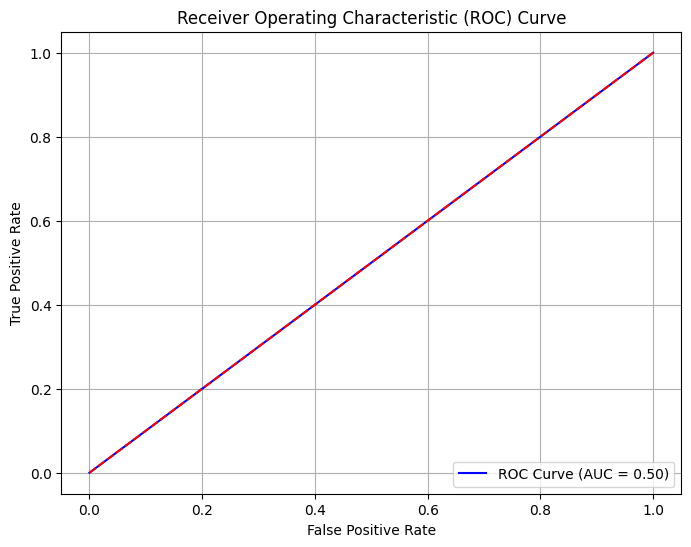

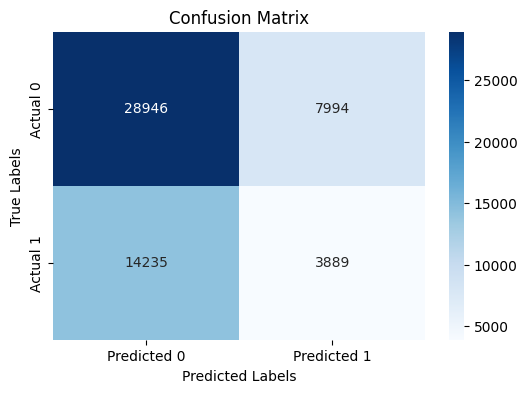

In [7]:
plot_evaluation_insights(y_test_pre, y_unbucketed_naive_pre, y_proba_unbucketed_naive_pre)

Accuracy: 0.7002
ROC AUC: 0.5000
Confusion Matrix:
[[118979  32566]
 [ 20828   5712]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82    151545
           1       0.15      0.22      0.18     26540

    accuracy                           0.70    178085
   macro avg       0.50      0.50      0.50    178085
weighted avg       0.75      0.70      0.72    178085



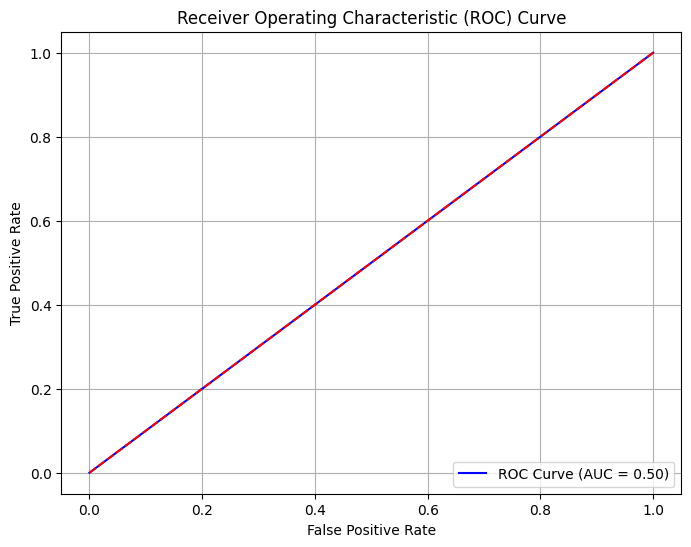

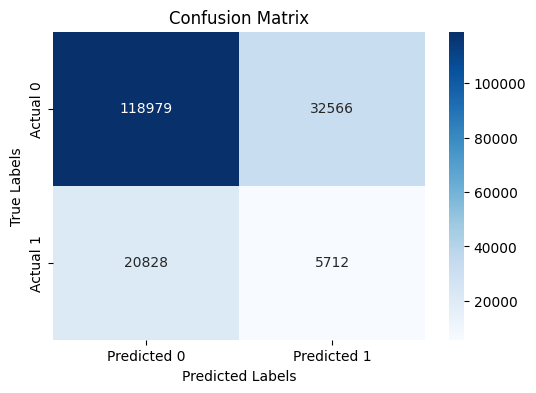

In [8]:
plot_evaluation_insights(y_test_post, y_unbucketed_naive_post, y_proba_unbucketed_naive_post)

Accuracy: 0.5443
ROC AUC: 0.5000
Confusion Matrix:
[[23655 13285]
 [11805  6319]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65     36940
           1       0.32      0.35      0.33     18124

    accuracy                           0.54     55064
   macro avg       0.49      0.49      0.49     55064
weighted avg       0.55      0.54      0.55     55064



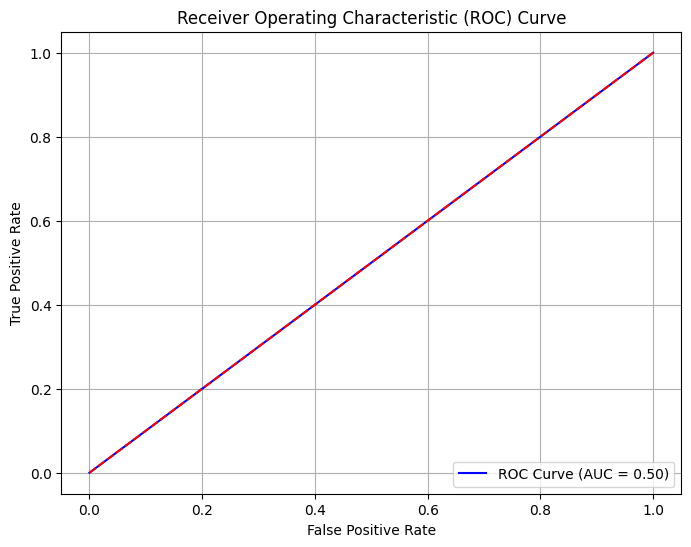

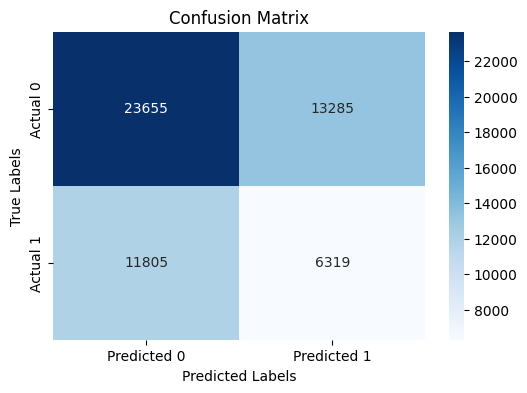

In [9]:
plot_evaluation_insights(y_test_pre, y_naive_pre, y_proba_naive_pre)

Accuracy: 0.7292
ROC AUC: 0.5000
Confusion Matrix:
[[125517  26028]
 [ 22198   4342]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84    151545
           1       0.14      0.16      0.15     26540

    accuracy                           0.73    178085
   macro avg       0.50      0.50      0.50    178085
weighted avg       0.74      0.73      0.74    178085



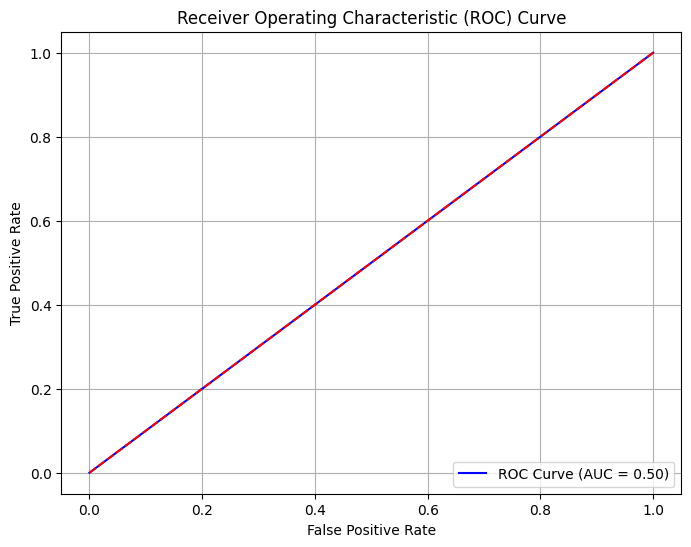

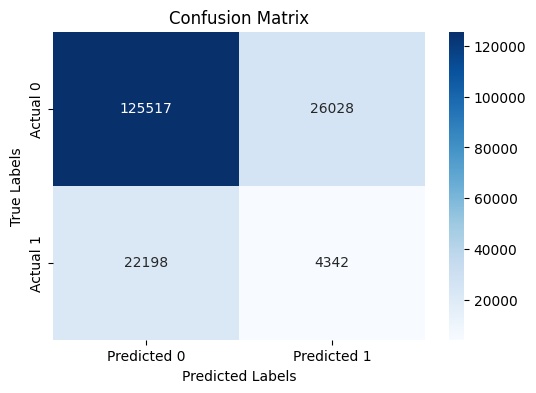

In [10]:
plot_evaluation_insights(y_test_post, y_naive_post, y_proba_naive_post)

# Define functions for training Random Forest model, obtaining predictions and feature importance

In [11]:
def train_random_forest_model(X_train, y_train):
    # Perform scaling
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both train and test sets
    X_train_scaled = scaler.fit_transform(X_train)

    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )

    # Train the model
    rf.fit(X_train_scaled, y_train)
    return rf, scaler  # return the trained model and the fitted scaler, to apply on testing data as well


def obtain_test_predictions(X_test, rf, scaler):
    # Make predictions
    X_test_scaled = scaler.transform(X_test)
    y_pred = rf.predict(X_test_scaled)
    y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
    return y_pred, y_pred_proba


def random_forest_feature_importance(X_train, rf):
    # -----------------------------------
    # Feature Importance
    # -----------------------------------

    # Extract feature importances
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)

    # Display top 10 features
    top_n = 10
    top_features = feature_importances_sorted.head(top_n)
    print(f"Top {top_n} Features:")
    print(top_features)

    # Plot top features
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


# Train and evaluate the Post-Offer model

C:\Users\20203666\.conda\envs\processmining2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8695
ROC AUC: 0.9104
Confusion Matrix:
[[142052   9493]
 [ 13751  12789]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92    151545
           1       0.57      0.48      0.52     26540

    accuracy                           0.87    178085
   macro avg       0.74      0.71      0.72    178085
weighted avg       0.86      0.87      0.86    178085



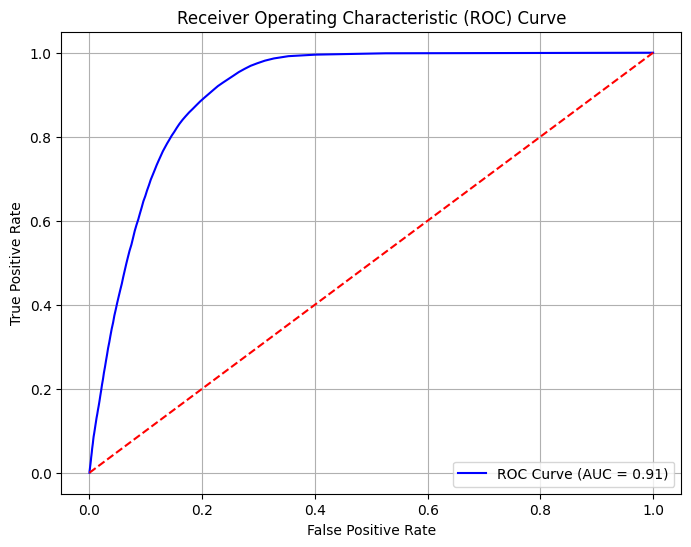

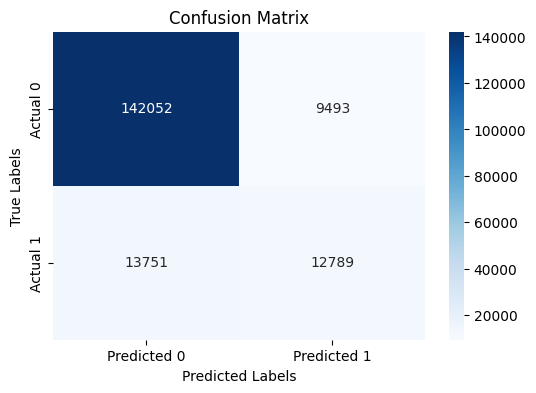

Top 10 Features:
CreditScore                    0.319659
W_Validate application_freq    0.068416
total_time_prefix              0.065667
prefix_average_time            0.048303
MonthlyCost                    0.046342
W_Call after offers_freq       0.045748
FirstWithdrawalAmount          0.038725
NumberOfTerms                  0.037869
OfferedAmount                  0.035329
prefix_length                  0.033344
dtype: float64


C:\Users\20203666\AppData\Local\Temp\ipykernel_15136\2796711787.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


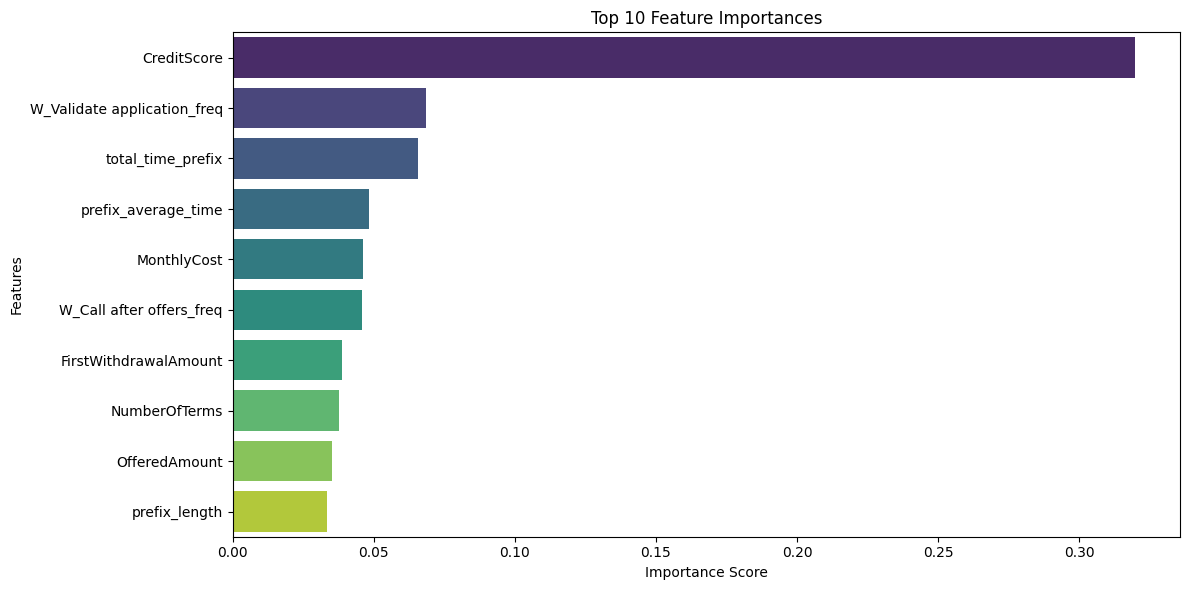

In [12]:
rf_post, scaler_post = train_random_forest_model(X_train_post, y_train_post)
y_pred_post, y_pred_proba_post = obtain_test_predictions(X_test_post, rf_post, scaler_post)
plot_evaluation_insights(y_test_post, y_pred_post, y_pred_proba_post)
random_forest_feature_importance(X_train_post, rf_post)

# Train and evaluate the Pre-Offer model

C:\Users\20203666\.conda\envs\processmining2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.5908
ROC AUC: 0.5215
Confusion Matrix:
[[26865 10075]
 [12458  5666]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.70     36940
           1       0.36      0.31      0.33     18124

    accuracy                           0.59     55064
   macro avg       0.52      0.52      0.52     55064
weighted avg       0.58      0.59      0.58     55064



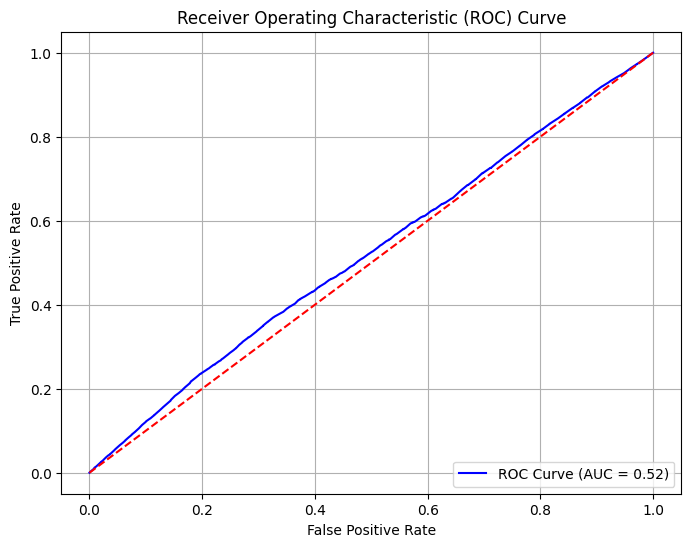

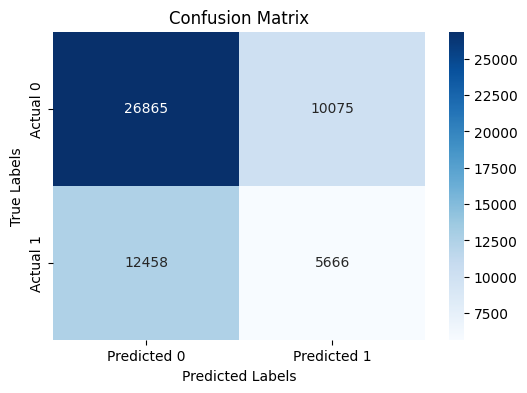

Top 10 Features:
prefix_average_time                 0.348920
total_time_prefix                   0.334721
case:RequestedAmount                0.191407
prefix_length                       0.023762
W_Complete application_freq         0.019198
W_Handle leads_freq                 0.017035
case:ApplicationType_New credit     0.007110
case:ApplicationType_Limit raise    0.005256
case:LoanGoal_Home improvement      0.004554
A_Submitted_freq                    0.004520
dtype: float64


C:\Users\20203666\AppData\Local\Temp\ipykernel_15136\2796711787.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


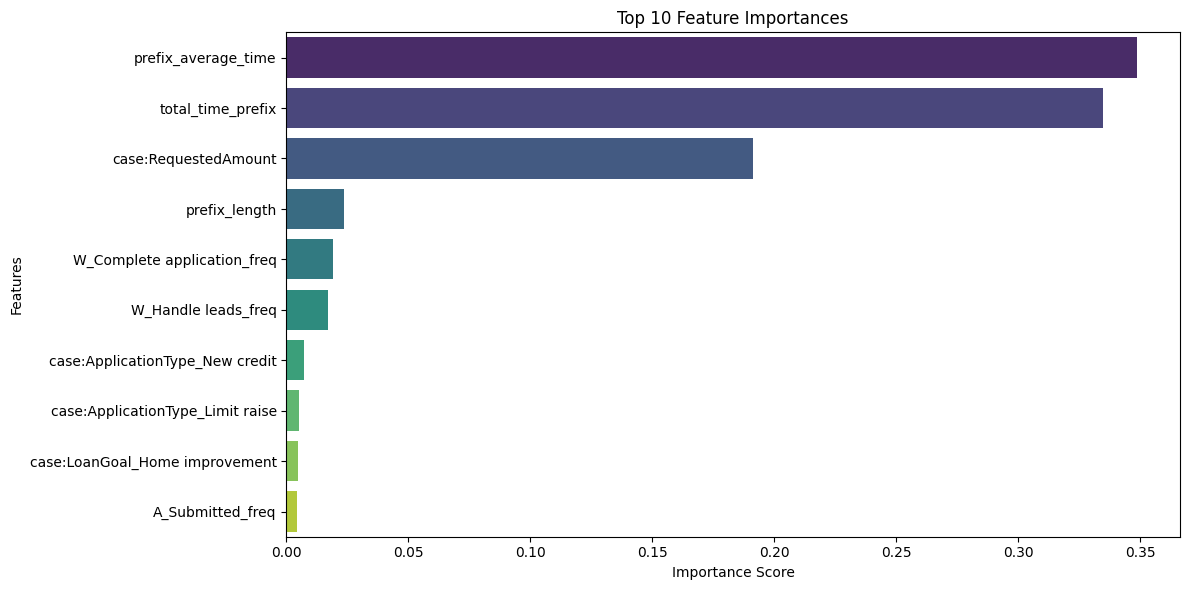

In [13]:
rf_pre, scaler_pre = train_random_forest_model(X_train_pre, y_train_pre)
y_pred_pre, y_pred_proba_pre = obtain_test_predictions(X_test_pre, rf_pre, scaler_pre)
plot_evaluation_insights(y_test_pre, y_pred_pre, y_pred_proba_pre)
random_forest_feature_importance(X_train_pre, rf_pre)

In [14]:
def make_accuracy_prefix_length_plot(X_test, y_test, rf, scaler, post_or_pre = 'post'):
    test_df = X_test.join(y_test, how='left')
    prefix_accuracy_dict = {}
    for length in test_df['prefix_length'].unique():
        test_df_filtered = test_df[test_df['prefix_length']==length]
        y_pred_filtered, y_pred_proba_filtered = obtain_test_predictions(test_df_filtered.loc[:, test_df.columns != 'event_of_interest_occured'], rf, scaler)
        y_test_filtered = test_df_filtered.loc[:, test_df.columns == 'event_of_interest_occured']
        accuracy = np.mean(y_test_filtered['event_of_interest_occured'].tolist() == y_pred_filtered)
        prefix_accuracy_dict[length] = accuracy
        
    test_df['max_prefix_length'] = (test_df['prefix_length'] > test_df['prefix_length'].shift(1)) & (test_df['prefix_length'] > test_df['prefix_length'].shift(-1))

    mean_prefix_length = np.mean(test_df.loc[test_df['max_prefix_length'], 'prefix_length'].tolist())
    prefix_accuracy_dict = dict(sorted(prefix_accuracy_dict.items(), key=lambda item: item[0]))
    
    x = list(prefix_accuracy_dict.keys())
    y = list(prefix_accuracy_dict.values())
    
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_ylim(0.5,1.01)  # Sets the y-axis range to [0, 30]
    ax.axvline(x=mean_prefix_length, color='red', linestyle=':', linewidth=2)
    ax.set_xlabel('Prefix length')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy of the {post_or_pre} offer model against the prefix length')
    ax.grid(True)
    fig.show()

C:\Users\20203666\AppData\Local\Temp\ipykernel_15136\3403317883.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


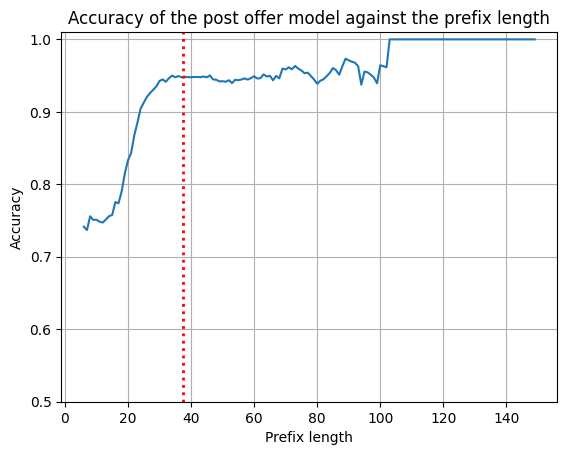

In [15]:
make_accuracy_prefix_length_plot(X_test_post, y_test_post, rf_post, scaler_post)

In [28]:
cases_with_cancelled = df_bpi[df_bpi['event'] == 'A_Cancelled']['case'].unique()

# Filter the DataFrame to include only rows belonging to these cases
cancelled_df = df_bpi[df_bpi['case'].isin(cases_with_cancelled)]

In [35]:
# Group by case_id to perform calculations
case_stats_cancelled = cancelled_df.groupby('case').agg(
    case_length=('event', 'count'),  # Count the number of events per case
    case_duration=('time', lambda x: (x.max() - x.min()).total_seconds())  # Calculate duration in seconds
)

# Calculate the mean values
mean_case_length_cancelled = case_stats_cancelled ['case_length'].mean()
mean_case_time_cancelled = case_stats_cancelled ['case_duration'].mean()/60/60/24
print(mean_case_length_cancelled , mean_case_time_cancelled , mean_case_time_cancelled/mean_case_length_cancelled*24)

26.24379254146295 29.887714099602277 27.332373446298732


In [36]:

notc_df = df_bpi[~df_bpi['case'].isin(cases_with_cancelled)]

In [37]:
# Group by case_id to perform calculations
case_stats_notc = notc_df.groupby('case').agg(
    case_length=('event', 'count'),  # Count the number of events per case
    case_duration=('time', lambda x: (x.max() - x.min()).total_seconds())  # Calculate duration in seconds
)

# Calculate the mean values
mean_case_length_notc = case_stats_notc ['case_length'].mean()
mean_case_time_notc= case_stats_notc['case_duration'].mean()/60/60/24
print(mean_case_length_notc , mean_case_time_notc,  mean_case_time_notc/mean_case_length_notc*24)

44.05152291488756 17.946481013218538 9.777540384913257


In [38]:
df_bpi['event_index'] = df_bpi.groupby('case').cumcount() + 1  # Assign an index to each event in a case, starting at 1

# Filter the rows where the event is 'A_Cancelled'
cancelled_events = df_bpi[df_bpi['event'] == 'A_Cancelled']

# Calculate the mean index
mean_index_cancelled = cancelled_events['event_index'].mean()
mean_index_cancelled

np.float64(23.995685936151855)

In [47]:


# Step 2: Identify the earliest times for each relevant event within each case.
# We'll group by ['case', 'event'] and pick the minimum timestamp for each combination.
grouped = df_bpi.groupby(['case', 'event'])['time'].min().unstack()

# The result is a pivoted table with one row per case and columns for each event,
# where grouped['O_create Offer'] is the earliest "O_create Offer" timestamp,
# and grouped['A_Cancelled'] is the earliest "A_Cancelled" timestamp.

# Step 3: Compute duration from first O_create Offer to first A_Cancelled
grouped['duration'] = grouped['A_Cancelled'] - grouped['O_Create Offer']

# Step 4: Calculate the mean duration across cases
mean_duration = grouped['duration'].mean()

print("Mean time from first O_create Offer to first A_Cancelled:", mean_duration)


Mean time from first O_create Offer to first A_Cancelled: 28 days 03:28:08.307510785
